In [2]:
########################################
''' Imports '''

from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
import os, csv
import random
from random import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image 
from IPython.display import display 
from PIL import Image
from PIL import ImageFile 

from tqdm import tqdm

from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs

import tensorflow as tf
from object_detection.utils import dataset_util

print("Import finished")

Import finished


In [3]:
########################################
''' Class '''

class Traffic_Sign:
    """ A Single Traffic sign model """
    
    def __init__(self, filePath, fileName, width, height, x1, y1, x2, y2, classTxt, classID):
        self.filePath = filePath
        self.fileName = fileName
        self.width = width
        self.height = height
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.classTxt = classTxt
        self.classID = classID  
        

In [4]:
########################################
''' Print helper function '''

# pretty print Traffic Sign object
def ts_pretty_print(ts):
    print("File: {} has name {}, with classID: {}".format(ts.fileName, ts.classTxt, ts.classID))
    


In [18]:
'''Mac'''
'''
TSName_txt_path = "/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Dataset/reducedSetTS.txt"
label_map_output_path = "/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/obj_detection/data/TS_label_map.pbtxt"

# All standard pictures in this folder are with its class name and .png format e.g. A1A.png
standard_folder = "/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Standards"
standard_img_extension = ".png"

# dataset path
dataset_directory = "/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Dataset"
training_dataset_directory = os.path.join(dataset_directory, "Training")
testing_dataset_directory = os.path.join(dataset_directory, "Testing")

# Store all images in png under training/testing folder
png_training_dataset_dir = os.path.join(dataset_directory, 'png_training')
png_testing_dataset_dir = os.path.join(dataset_directory, 'png_testing')
'''


'''Windows'''

TSName_txt_path = "C:/Users/ksu/Desktop/ML/TSR_capstone/MLND_Traffic_Sign_Recognition/Dataset/reducedSetTS.txt"
label_map_output_path = "C:/Users/ksu/Desktop/ML/TSR_capstone/MLND_Traffic_Sign_Recognition/obj_detection/data/TS_label_map.pbtxt"

# All standard pictures in this folder are with its class name and .png format e.g. A1A.png
standard_folder = "C:/Users/ksu/Desktop/ML/TSR_capstone/MLND_Traffic_Sign_Recognition/Standards/"
standard_img_extension = ".png"

# dataset path
dataset_directory = "C:/Users/ksu/Desktop/ML/TSR_capstone/MLND_Traffic_Sign_Recognition/Dataset"
training_dataset_directory = os.path.join(dataset_directory, "Training")
testing_dataset_directory = os.path.join(dataset_directory, "Testing")

# Store all images in png under training/testing folder
png_training_dataset_dir = os.path.join(dataset_directory, 'png_training')
png_testing_dataset_dir = os.path.join(dataset_directory, 'png_testing')

# tfRecords output path
tfRecordsDir = "C:/Users/ksu/Desktop/ML/TSR_capstone/MLND_Traffic_Sign_Recognition/obj_detection/tfRecords"


In [6]:
''' TS_label_map generator '''

def label_generator(TSName_62_collection):
    label_map_content = ""
    num_of_classes = 62
    for i in range(num_of_classes):
        label_map_content += "item{\n"
        label_map_content += "  id: {}\n".format(str(i+1))
        label_map_content += "  name: {}\n".format(TSName_62_collection[i])
        label_map_content += "}\n\n"
        
    with open(label_map_output_path, "w") as fout:
        fout.write(label_map_content) 

        
# create classID and className pairs for 62 Traffic Signs
with open(TSName_txt_path) as f:
    TSName_62 = f.readlines()
# remove whitespace characters
TSName_62 = [x.strip() for x in TSName_62[0:]]


# Generate label map for obj_detection
label_generator(TSName_62)

In [7]:
''' ppm to png converter generator '''

# png_dataset_dir: destination of png files of either training datasets and testing datasets
# img_path: the path to one single ppm image file. 

def convert_ppm_to_png(png_dataset_dir, ppm_img_path, ppm_img_name):
    # if this path doesn't exist, create 
    if not os.path.exists(png_dataset_dir):
        os.makedirs(png_dataset_dir)

    if ppm_img_name[-3:] == "ppm":
        img = Image.open(ppm_img_path)
        png_path = os.path.join(png_dataset_dir, ppm_img_name[:-3]+'png')
        #print(png_path)
        img.save(png_path)
        #img.show()
        return png_path
    else:
        print("Non ppm file detected: {}".format(ppm_img_name))
        

In [ ]:
########################################
''' Load dataset into variable '''
    

# function to load training, test, and validation datasets into variables 
def load_dataset(path, png_dataset_dir):
    all_files = []
    print("Loading {}".format(path))
    for eachfolder in os.listdir(path):
        abs_loc = os.path.join(path, eachfolder)
        png_class_dir = os.path.join(png_dataset_dir, eachfolder)
        if not os.path.isdir(abs_loc):
            continue

        #open csv for this folder
        with open(abs_loc + "/GT-" + eachfolder + ".csv", "r") as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=';')
            next(csv_reader, None) # skip header
            
            #create traffic sign object
            for row in csv_reader:
                abs_file_loc = os.path.join(abs_loc, row[0])
                png_file_loc = convert_ppm_to_png(png_class_dir, abs_file_loc, row[0]) #dir of png files, path of ppm file, name of ppm file
                all_files.append(Traffic_Sign(png_file_loc, row[0], row[1], row[2], row[3], row[4], row[5], row[6], TSName_62[int(row[7])], row[7]))
                
            csv_file.close()
        
        print("folder: {} completed".format(eachfolder))
    return all_files



# load train and test datasets into list of objects of Traffic signs
#all_training_objs = load_dataset("/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Dataset/Training") # a list of training traffic_sign_collection
#all_testing_and_validation_objs = load_dataset("/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Dataset/Testing")  # a list of testing traffic_sign_collection

all_training_objs = load_dataset(training_dataset_directory, png_training_dataset_dir) # a list of training traffic_sign_collection
all_testing_and_validation_objs = load_dataset(testing_dataset_directory, png_testing_dataset_dir)  # a list of testing traffic_sign_collection

# shuffle training objects and testing objects 
shuffle(all_training_objs)
shuffle(all_testing_and_validation_objs)

In [12]:
# random test of object
ts_pretty_print(all_training_objs[random.randint(0, len(all_training_objs))])
print("Total number of training obj: {}".format(str(len(all_training_objs))))
print("Total number of testing obj: {}".format(str(len(all_testing_and_validation_objs))))

File: 00942_00000.ppm has name B1, with classID: 19
Total number of training obj: 4591
Total number of testing obj: 2534


In [31]:
def create_TS_tf_example(TS_obj): 
    height = int(TS_obj.height)
    width = int(TS_obj.width)
    filename = TS_obj.fileName
    
    with tf.gfile.GFile(TS_obj.filePath, 'rb') as fid:
        encoded_image_data = fid.read()

    image_format = b'png'

    xmins = [float(TS_obj.x1) / float(width)]
    xmaxs = [float(TS_obj.x2) / float(width)]
    ymins = [float(TS_obj.y1) / float(height)]
    ymaxs = [float(TS_obj.y2) / float(height)]
    
    classes_text = [TS_obj.classTxt.encode('utf8')]
    classes = [int(TS_obj.classID)]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [33]:
# define tfRecord writter 
tfRecordsPath = os.path.join(tfRecordsDir, "training.tfrecords")
writer = tf.python_io.TFRecordWriter(tfRecordsPath)

for TS_obj in all_training_objs:
    tf_example = create_TS_tf_example(TS_obj)
    writer.write(tf_example.SerializeToString())

writer.close()
print("Finish converting training objects to tfRecords")

Finish converting training objects to tfRecords


In [ ]:
''' Modify config files of the chosen pre-trained model '''
''' Chosen model: faster_rcnn_inception_v2_coco '''



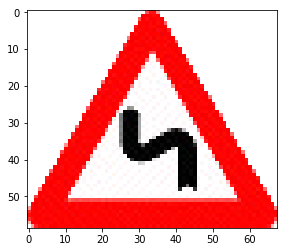

/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Standards/A1C.png


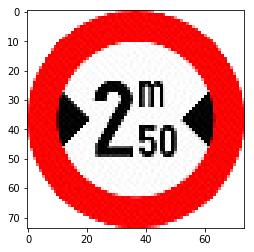

/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Standards/C27.png


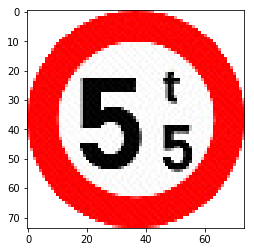

/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Standards/C21.png


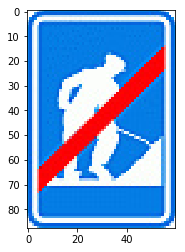

/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Standards/F47.png


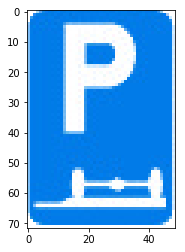

/Users/kevinsu/Desktop/Udacity/machine-learning-master/projects/capstone/TSR/Standards/E9e.png


In [96]:
########################################
''' Load the definition (standards) of our 62 traffic sign images '''
''' from 210 total traffic sign image dataset '''
def show_my_image(img_path):
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    

# display some standard images
for i in range(5):
    img_name = TSName_62[random.randint(0, 61)] + standard_img_extension
    img_path = os.path.join(standard_folder, img_name)
    show_my_image(img_path)
    print(img_path)
